In [2]:
import scipy
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageOps
from copy import copy, deepcopy
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import os
import glob
from PIL import Image, ImageOps
from scipy import ndimage, misc
import scipy.misc
from skimage.restoration import denoise_tv_chambolle
from sklearn.mixture import GaussianMixture
import statistics

In [3]:
def median_filter(image, kernel_size):
    """Apply a median filter to an image.
    
    Parameters
    ----------
    image : array_like
        Input image.
    kernel_size : int
        Size of the median filter kernel.
    
    Returns
    -------
    image_filtered : array_like
        Filtered image.
    """

    assert kernel_size % 2 == 1 # Kernel size must be odd
    assert kernel_size > 1 #Kernel size must be greater than 1

    return scipy.ndimage.median_filter(image, kernel_size)

# Pipeline is: 
### Pre-processing: histogram equalization --> median filter/gray matter subtraction --> total variation
### Segmentation: gaussian mixture Model --> parameter estimation
### Post-processing: intensity and area constraint --> midline Patter Matching --> bright objects and edge removal

# Load the Image(s)

In [4]:
# load in every image in a given folder


path = '/Users/amandabreton/Documents/Duke 2022-2023/ECE 588/CTscans/Patients_CT/'  # point to correct folder

# cur_num represents patient number - used for finding them in directory
cur_num = 49
images = []

# 81 patients in total
for patient in range(81):
    # get filenames for each patient
    filenames = glob.glob(path + "0" + str(cur_num) + "/brain/" + "*.jpg")

    # get each scan for each patient
    for f in filenames:

        # read in the image
        img = cv2.imread(f)
        images.append(img)
        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        #print(Image.fromarray(img))

        cur_num += 1
# to access each image: plt.imshow(images[50], cmap='gray')

# Single Raw Image 

(-0.5, 649.5, 649.5, -0.5)

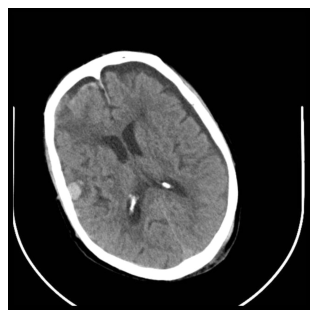

In [5]:
figure(figsize=(5, 5), dpi=80)
im = plt.imread(path+ '092/brain/20.jpg')
plt.imshow(im, cmap='gray')
plt.axis('off')

# Preprocessing

## Histogram Equalization
for presentation, maybe display histograms of not equalized and equalized 

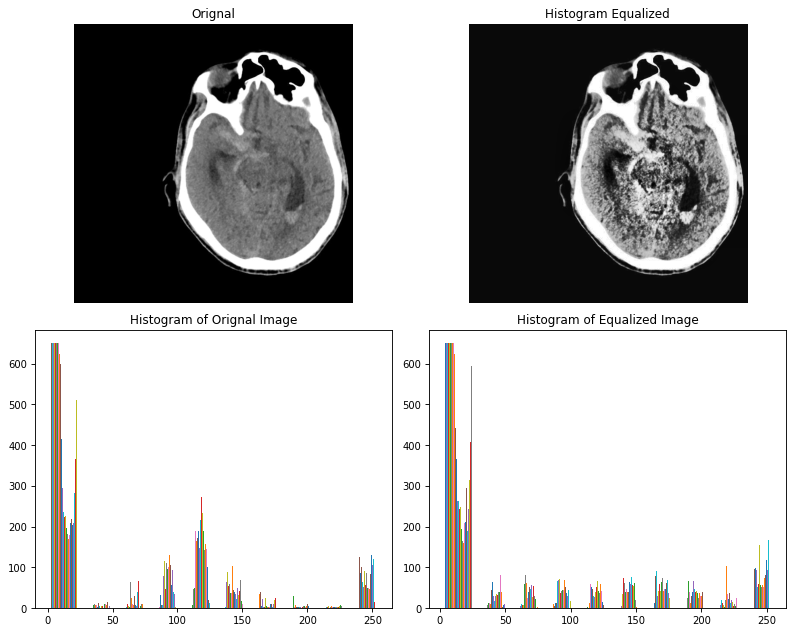

In [32]:
#im = cv2.imread(path+ '092/brain/20.jpg',0) # YOU NEED THE 0 IN FOR THIS TO WORK 
#bone = cv2.imread(path+ '092/bone/20.jpg',0)
#im = cv2.imread(path+ '069/brain/18.jpg',0) 
#bone = cv2.imread(path+ '069/bone/18.jpg',0)

im = cv2.imread(path+ '080/brain/14.jpg',0) 
bone = cv2.imread(path+ '080/bone/14.jpg',0)
answer = cv2.imread(path+ '080/brain/14_HGE_Seg.jpg')

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# special histogram equalization where picture is broken up into blocks, equalized separately, 
# and then put back together

#clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8)) # histogram equalization parameters
clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(5,5))
he_im = clahe.apply(im) # apply the histogram equalization to the image (im)

#res = np.hstack((im,final_image))
figure(figsize=(10, 8), dpi=80)
#plt.imshow(res, cmap="gray")
plt.subplot(2,2,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')
plt.subplot(2,2,3)
plt.hist(im)
plt.title("Histogram of Orignal Image")
plt.subplot(2,2,4)
plt.hist(he_im)
plt.title("Histogram of Equalized Image")
plt.tight_layout()

## Median Filter 

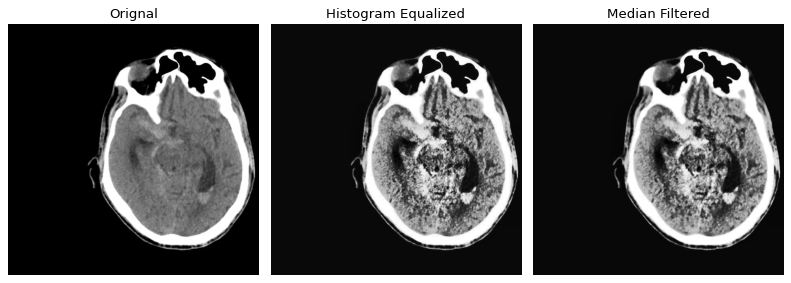

In [7]:
#Image.fromarray(median_filter(im,3))
figure(figsize=(10, 8), dpi=80)
#previous images
plt.subplot(1,3,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')

# median filter
med_im = median_filter(he_im,3)
plt.subplot(1,3,3)
plt.imshow(med_im, cmap='gray')
plt.title('Median Filtered')
plt.axis('off')
plt.tight_layout()

### Exploration: Median Filtered Image - Orignal 

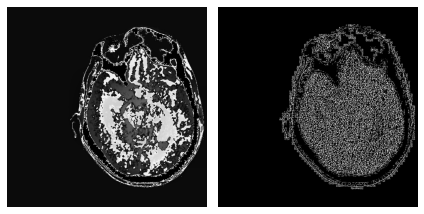

In [8]:
plt.subplot(1,2,1)
plt.imshow(med_im-im, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(med_im-he_im, cmap = 'gray')
plt.axis('off')
plt.tight_layout()

## Gray matter subtraction (GMS): 
In this stage the gray matter intensity is removed from the image by subtracting the maximum intensity level of the histogram from the image. 

255
255


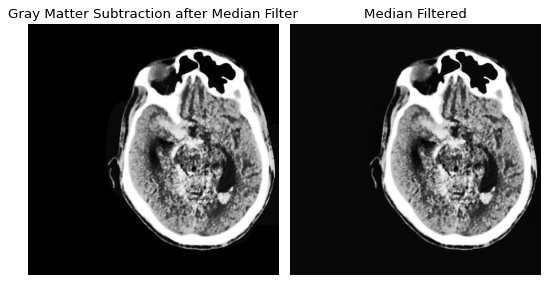

In [9]:
flat_med_im = med_im.flatten()
max_intens = statistics.mode(flat_med_im)
#max_intens = np.max(flat_med_im)

mask = (med_im != max_intens)
#mask2 = (med_im != 255)
#gms_im = med_im*mask*mask2
gms_im = med_im*mask
figure(figsize=(10, 8), dpi=80)
plt.subplot(1,3,1)
plt.imshow(gms_im, cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.title('Gray Matter Subtraction after Median Filter')

plt.subplot(1,3,2)
plt.imshow(med_im, cmap='gray')
plt.title('Median Filtered')
plt.axis('off')
print(np.max(med_im))
print(np.max(gms_im))
#plt.subplot(1,3,3)
#plt.imshow(gms_im-med_im, cmap='gray')
#plt.title('GM - Median')
#plt.axis('off')

## Total Variation 

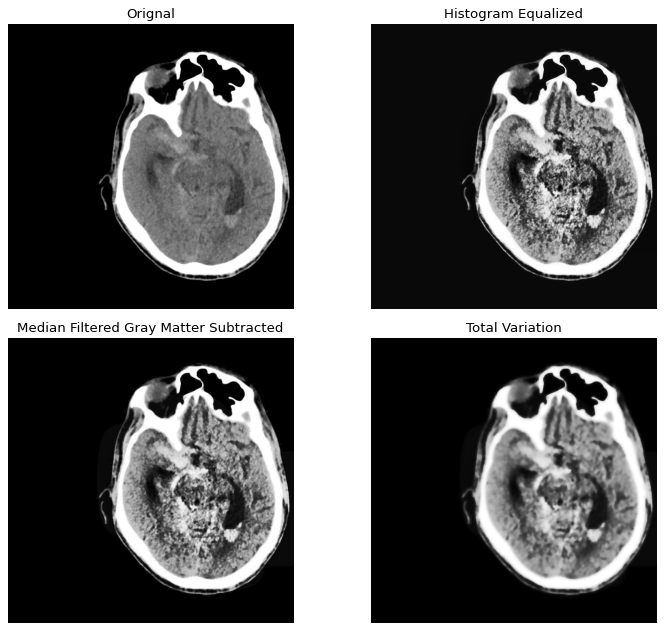

In [10]:
figure(figsize=(10, 8), dpi=80)
#previous images
plt.subplot(2,2,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(gms_im, cmap='gray')
plt.title('Median Filtered Gray Matter Subtracted')
plt.axis('off')

# total variation
tv_im = denoise_tv_chambolle(gms_im, weight=0.25)
# The greater weight, the more denoising (at the expense of fidelity to input).
plt.subplot(2,2,4)
plt.title('Total Variation')
plt.imshow(tv_im, cmap='gray')
plt.axis('off')
plt.tight_layout()
tv_im = np.round(tv_im*255)

### histogram of total variation

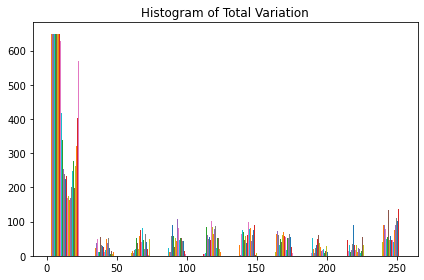

In [11]:
plt.hist(tv_im)
plt.title("Histogram of Total Variation")
plt.tight_layout()

### How total variation changed from original image and last step 

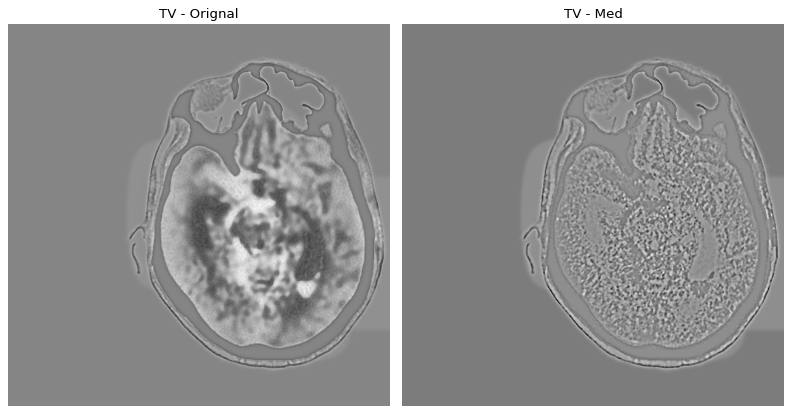

In [12]:
figure(figsize=(10, 8), dpi=80)
plt.subplot(1,2,1)
plt.imshow(tv_im-im, cmap = 'gray')
plt.title('TV - Orignal')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(tv_im-med_im, cmap = 'gray')
plt.title('TV - Med')
plt.axis('off')
plt.tight_layout()

# Segmentation

# Trying Otsu's Method
% Gaussian Mixture Model 
% https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_GMM.html

threshold is 88.0


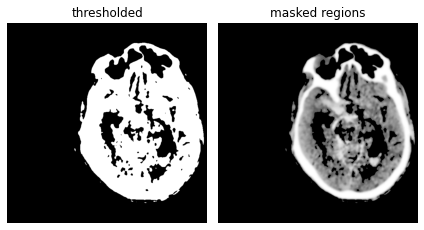

In [13]:
#print(tv_im.shape)
# don't need to convert to gray because we did that earlier 
#gray = cv2.cvtColor(tv_im, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(tv_im, (7, 7), 0)
blurred = np.asarray(blurred, dtype = 'uint8')
#(T, threshInv) = cv2.threshold(blurred, np.min(blurred), np.max(blurred), cv2.THRESH_BINARY | cv2.THRESH_OTSU)
(T, threshInv) = cv2.threshold(blurred, np.min(blurred), np.max(blurred),cv2.THRESH_OTSU)
print('threshold is ' + str(T))
plt.subplot(1,2,1)
plt.imshow(threshInv, cmap = 'gray')
plt.axis('off')
plt.title('thresholded')
plt.subplot(1,2,2)
## visualize only the masked regions in the image
masked = cv2.bitwise_and(blurred, blurred, mask=threshInv)
plt.imshow(masked, cmap = 'gray')
plt.title('masked regions')
cv2.waitKey(0)
plt.axis('off')
plt.tight_layout()

254
253


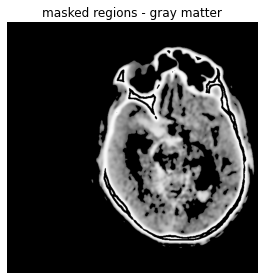

In [14]:
flat_mask = masked.flatten()
flat_mask = [i for i in flat_mask if i != 0]
max_intens = statistics.mode(flat_mask)
print(max_intens)
mask = (masked != max_intens)
gms2_im = masked*mask

flat_gms2 = gms2_im.flatten()
flat_mask = [i for i in flat_gms2 if i != 0]
max_intens = statistics.mode(flat_mask)
print(max_intens)
mask = (gms2_im != max_intens)
gms3_im = gms2_im*mask

plt.imshow(gms3_im, cmap = 'gray')
plt.title('masked regions - gray matter')
plt.axis('off')
plt.tight_layout()

In [15]:
th3 = cv2.adaptiveThreshold(gms3_im,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

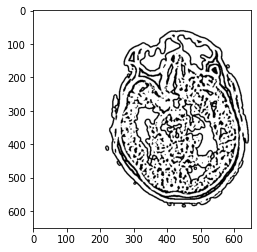

In [16]:
plt.imshow(th3, cmap = 'gray')

(array([[650.,   0.,   0., ...,   0.,   0.,   0.],
        [650.,   0.,   0., ...,   0.,   0.,   0.],
        [650.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [650.,   0.,   0., ...,   0.,   0.,   0.],
        [650.,   0.,   0., ...,   0.,   0.,   0.],
        [650.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 650 BarContainer objects>)

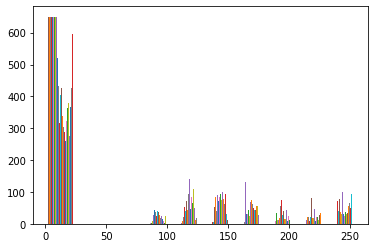

In [17]:
plt.hist(gms3_im)

# Multi Otsu

[ 37.35351562  98.11523438 147.91992188 205.69335938]
[205.69335938]


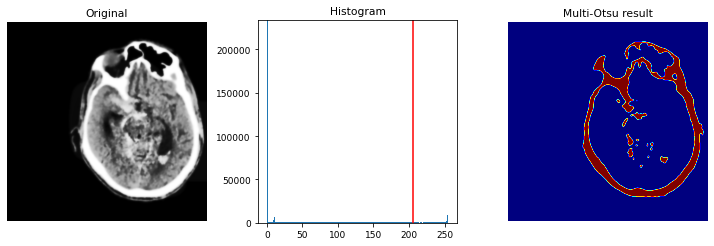

In [18]:
from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
plt.rcParams['font.size'] = 9

# The input image.
#image = tv_im
image = ndimage.gaussian_filter(tv_im, 1)
# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image, classes=5)
print(thresholds)
thresholds = thresholds[3:]
print(thresholds)
# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
mode = statistics.mode(tv_im.flatten())
most = np.count_nonzero(tv_im == mode)

ax[1].set_ylim(top=most+1)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

(-0.5, 649.5, 649.5, -0.5)

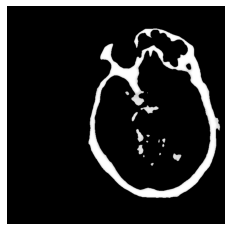

In [19]:
new = regions*tv_im
plt.imshow(new, 'gray')
plt.axis('off')

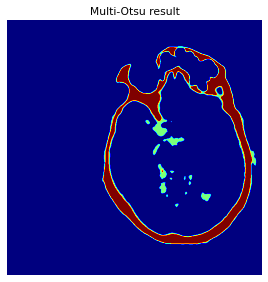

In [20]:
thresholds = threshold_multiotsu(new, classes=3)
#thresholds = thresholds[1:]
regions = np.digitize(new, bins=thresholds)

# Plotting the Multi Otsu result.

plt.imshow(regions, cmap='jet')
plt.title('Multi-Otsu result')
plt.axis('off')

plt.tight_layout()
plt.show()

# Segment Bone

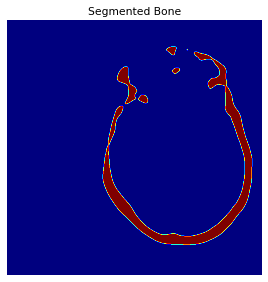

In [21]:
bone = ndimage.gaussian_filter(bone, 5)
thresholds = threshold_multiotsu(bone, classes=3)
thresholds = thresholds[1:]
bone_mask = np.digitize(bone, bins=thresholds)

# Plotting the Multi Otsu result.
plt.imshow(bone_mask, cmap='jet')
plt.title('Segmented Bone')
plt.axis('off')
plt.tight_layout()
plt.show()

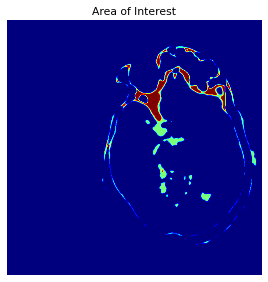

In [22]:
#brain_no_bones = (regions!=bone_mask)
bone_mask=(bone_mask==0)
brain_no_bones = regions * bone_mask
plt.imshow(brain_no_bones, cmap='jet')
plt.title('Area of Interest')
plt.axis('off')
plt.tight_layout()
plt.show()

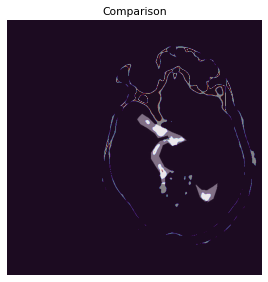

In [45]:
#overlaying our segmentation with theirs 
plt.imshow(brain_no_bones, cmap='twilight_shifted')
plt.imshow(answer, cmap = 'gray', alpha = 0.4)
plt.title('Comparison')
plt.axis('off')
plt.tight_layout()
plt.show()